In [236]:
#import basic system functions
import os
import datetime
from collections import Counter

#import libraries for data wrangling
import pandas as pd
import numpy as np

#import libraries for plotting data
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#import libraries for time series analysis
from fbprophet import Prophet

#import libraries to evaluate model performance
import sklearn.metrics as metrics

In [237]:
#set random seed so that experiments are replicable
np.random.seed(12)

In [238]:
#import list with features descriptions
feature_description = pd.read_csv('meteolytix_Artikelgruppen.csv')

#create dictionary with article group descriptions
article_names = {int(item[:2].replace(';','')):item[2:].replace(';','').replace(' ','') for item in feature_description['Artikelgruppe;Name']}
article_names

#delete feature description dataframe
del feature_description

In [239]:
#create dataframe with original data that will not be touched throughout notebook
original_data = pd.read_csv('meteolytix_Artikelgruppen_Umsatz_verschiedeneStandorte.csv') 

In [240]:
#set Datum to datetime format
original_data['Datum'] = pd.to_datetime(original_data['Datum'])

In [241]:
#convert date to index
original_data.set_index('Datum', inplace=True)
original_data.sort_index(inplace=True)

In [242]:
#convert Filiale and Artikel ID to integer
original_data.Filiale = [int(no) for no in original_data.Filiale]
original_data.Artikelgruppe = [int(no) for no in original_data.Artikelgruppe]

# Split dataset into train, validation & test

In [243]:
train_df = original_data[original_data.index.year < 2018]
validation_df = original_data[original_data.index.year == 2018]
test_df = original_data[original_data.index.year == 2019]
corona_df = original_data[original_data.index.year == 2020]

# Build pipeline to transform dataframes to desired format and add features

# Build naive model

## Naive prediction model as baseline

In later stages of the notebook, we will build sophisticated models to predict the revenue generated by each article group in each store for a given time period. To determine if a model is good or not, it has to be measured against some benchmark. In this case, our benchmark model will be a very simple technique: To predict the sales on a given day, we will just assume the same quantity as in a previous period (e.g. previous day or same day in previous week or previous year). Because we identified heavy inter-weekly patterns in the data, we will not use the previous day as a predictor but the same day in a previous period.

Since one store sells much more 'Brötchen' while the other has relatively high peaks in other categories, we will build a model for each product group for each store. This way, we avoid using the very same model for either one product category in all stores or for all product categories in one store. 

In [244]:
y_true = test_df.loc[(test_df.Filiale == 1)&(test_df.Artikelgruppe == 1)]['Umsatz'].sort_index()
def naive_lag_prediction(y_true, lag=7):
    return y_true.shift(lag)    

In [245]:
#create empty dataframe to store results of prediction iterations
naive_model_performance= pd.DataFrame(columns=['Filiale','Artikelgruppe','MAE','MED_AE','MSE','RMSE','R2','residuals'])
#iterate through all stores and article groups to predict each days revenue with the revenue from last week
for fil in train_df.Filiale.unique():
    for article in test_df.Artikelgruppe.unique():
        #generate series with true values
        y_true = test_df.loc[(test_df['Filiale'] == fil)&(test_df['Artikelgruppe'] == article)]['Umsatz'].sort_index(ascending=True)
        
        #predict values of series with value from 7 periods before (predict value for next Monday with value from this Monday)
        y_predict = naive_lag_prediction(y_true,lag=7)
         
        #delete first 7 digits for both series, because prediction contains NAN values
        y_true = y_true[7:]
        y_predict = y_predict[7:]
        
        #get model performance metrics
        try: 
            mae = metrics.mean_absolute_error(y_true,y_predict)
            medae = metrics.median_absolute_error(y_true,y_predict)
            mse = metrics.mean_squared_error(y_true,y_predict)
            rmse = np.sqrt(metrics.mean_squared_error(y_true,y_predict))
            r2 = metrics.r2_score(y_true,y_predict)

        except:
            pass
        naive_model_errors = list(y_predict - y_true)
        naive_model_performance = naive_model_performance.append({'Filiale':fil,'Artikelgruppe':article,'MAE':mae,'MED_AE':medae,'MSE':mse,'RMSE':rmse,'R2':r2,'residuals':naive_model_errors}, ignore_index=True)


Let's have a look at which group of articles is being predicted best and worst by the naive model

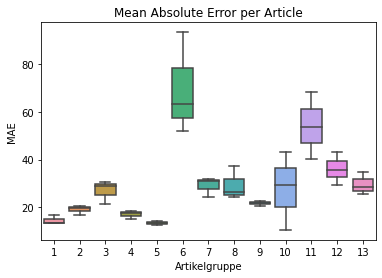

In [246]:
sns.boxplot(x = 'Artikelgruppe', y = 'MAE', data=naive_model_performance,orient='v')
plt.title('Mean Absolute Error per Article');

px.scatter(data_frame=naive_model_performance, x='Artikelgruppe', y= 'MAE',color='Filiale',title='Mean Absolute Error per Article and Store' )

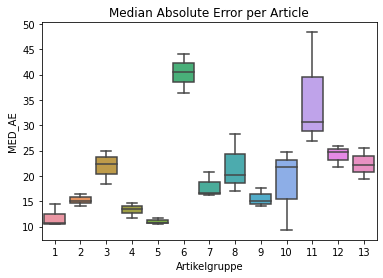

In [247]:
sns.boxplot(x = 'Artikelgruppe', y = 'MED_AE', data=naive_model_performance,orient='v')
plt.title('Median Absolute Error per Article');

px.scatter(data_frame=naive_model_performance, x='Artikelgruppe', y= 'MED_AE',color='Filiale',title='Median Absolute Error per Article and Store' )

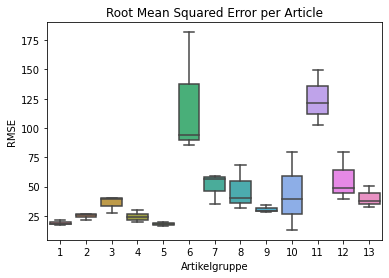

In [248]:
sns.boxplot(x = 'Artikelgruppe', y = 'RMSE', data=naive_model_performance,orient='v')
plt.title('Root Mean Squared Error per Article');

px.scatter(data_frame=naive_model_performance, x='Artikelgruppe', y= 'RMSE',color='Filiale',title='Root Mean Squared Error per Article and Store' )

The plots show that the model performs similar for all 3 stores. When it is good at predicting an article in store 1, it is also rather good at predicting the article in the other stores. The model is quite ok at predicting the sales of article groups 1-5 which are all related to whole loafs of bread. Article groups 6 (Brötchen) and 11 (Stückgebäck) seem to be less predictable with this model. The problems with article group 11 could be related to the fact that this article shows very high outliers at around new years eve. <br>

Interestingly, it is store 3 that generates the highest mean and median absolute error. This is the store located in the suburb and intuitively I would have thought that the sales at the beach are more dependent on external factors and thus fluctuate more from week to week. 

## Decide on which categories to predict
Before we create a model for each combination of store and article, we will pre-select the possible best fitting models using only a few article-store combinations to then only tune the hyperparameters for all individual combinations. 

The above plots indicate that the naive model is relatively good at predicting sales for article group 1 while the errors for article group 6 are rather high. These are also the article groups that generate the most revenue in all stores. To limit the initial computing expense, we will firstly only build models to predict the sales for these 2 article groups only in store 3. 

In [249]:
#create list with articles to predict sales for
article_selection = [1,6]

#create list with stores for which we want to forecast the sales
store_selection = [3]

#look at what articles stand behind each id
article_names

{1: 'Weizenbrot',
 2: 'Mischbrot',
 3: 'Vollkornbrot',
 4: 'Spezialbrot',
 5: 'Stangenbrote',
 6: 'Brötchen',
 7: 'SüßeBrötchen',
 8: 'HerzhafteBrötchen',
 9: 'KonditoreiBlech1',
 10: 'KonditoreiBlech2',
 11: 'Stückgebäck',
 12: 'Blechkuchen',
 13: 'Weihnachtsartikel'}

### Base model metrics
Let's get the RMSE of the base model for the selected articles.

In [251]:
for article in article_selection:
    for store in store_selection:
        rmse = naive_model_performance.loc[(naive_model_performance['Filiale'] == store) & (naive_model_performance['Artikelgruppe'] == article)]['RMSE'].values[0]
        print(f'Filiale {store}, article {article} \n Base RMSE: {rmse} \n\n')

Filiale 3, article 1 
 Base RMSE: 21.60808314273543 


Filiale 3, article 6 
 Base RMSE: 181.75954393940972 




# Data Preparation

## Pivot dataframe and split by store id

In [252]:
#function to extract data for only one store from dataframe and pivot the article column
def store_split(df, fil):
    date_df = pd.DataFrame(index=pd.date_range(start=df.index.min(), end=df.index.max()))
    dummy = pd.pivot_table(df[df.Filiale == fil],values='Umsatz',index=df[df.Filiale == fil].index,columns='Artikelgruppe', aggfunc=np.sum, fill_value=0)
    dummy = dummy.reindex(pd.date_range(start=df.index.min(), end=df.index.max())).fillna(0)
    return dummy

In [253]:
#iteratively generate individual train dataframes for each store
for fil in train_df.Filiale.unique():
    globals()['train_fil_'+str(fil)] = store_split(train_df,fil)
    
#iteratively generate individual train dataframes for each store
for fil in validation_df.Filiale.unique():
    globals()['validation_fil_'+str(fil)] = store_split(validation_df,fil)  
    
#iteratively generate individual train dataframes for each store
for fil in validation_df.Filiale.unique():
    globals()['test_fil_'+str(fil)] = store_split(test_df,fil)  

# Evaluation Functions
In order to evaluate all models in the same manner, we will create a few functions.

### MAPE
At first, let's create a function that calculates the mean absolute percentage error. It indicates by how many percentage points our predictions are off on average. Because the stores are closed on some days, we would have to divide by 0 to get the percentual deviation from the true value. Since this generates an error, we must create a function that ignores days on which y_true is 0. The logical reasoning behind it in this scenario is that any product will at least generate some revenue if it is being offered on a given day. Days with 0 revenue for a product mean that either the product was not baked that day or, if all other products are 0 as well, the store was closed. Both are scenarios that the bakery knows ahead of time and does not have to account for in a predictive model that tries to model the fluctuations in demand.

In [462]:
def get_pct_residuals(y_true,y_predict):
    '''Returns list with percentage errors for all observations where y_true not 0. Where y_true is 0, the percentage error is 0 as well'''
    return [(y_true[idx] - y_predict[idx])/y_true[idx] * 100 if y_true[idx] != 0 else 0 for idx,_ in enumerate(y_true) ]

In [464]:
#function to calculate MAPE for all observations where y_true is not 0
def get_mape(y_true, y_predict):
    '''Returns mean percentage error for all predictions where y_true is not 0. Where y_true is 0, the percentage error is 0 as well '''
    return np.mean([np.absolute(y_true[idx] - y_predict[idx])/y_true[idx] * 100 if y_true[idx] != 0 else 0 for idx,_ in enumerate(y_true) ])
    

### Residual Plots

Looking at the residuals and their distribution over time can tell us much about the flaws that the respective model has. Ideally, the residuals are stationary and close to 0

In [454]:
# Plot cumulative density function of residuals
def residual_cdf(data):
    '''Plots cdf of input data'''
    # sort the data:
    data_sorted = np.sort(data)

    # calculate the proportional values of samples
    p = 1. * np.arange(len(data)) / (len(data) - 1)

    # plot the sorted data:
    fig = plt.figure(figsize=(20,15))


    ax1 = fig.add_subplot(311)
    ax1.plot(data_sorted, p)
    ax1.set_title('Residuals Cumulative Distribution Function')
    ax1.set_xlabel('Residuals');
    ax1.set_ylabel('Cumulative Distribution');
    ax1.axvline(x=np.percentile(data,5),color='r') 
    ax1.axvline(x=np.percentile(data,95),color='r')

    ax2 = fig.add_subplot(312)
    ax2.plot([idx for idx,_ in enumerate(data)],data,'bo');
    ax2.plot([idx for idx,_ in enumerate(data)],np.zeros(len(data)),'r-');
    ax2.set_title('Residuals over time')
    ax2.set_xlabel('Time in days');
    ax2.set_ylabel('Residual');  

In [491]:
def plot_prediction(y_true,y_predict):
    '''Plots true and predicted values on same y-axis'''
    fig = plt.figure(figsize=(20,15))
    ax1 = fig.add_subplot(311)
    ax1.plot(range(len(y_true)), y_true,'bo')
    ax1.plot(range(len(y_predict)),y_predict,'r-')
    ax1.set_title('Complete prediction')
    
    ax2 = fig.add_subplot(312)
    ax2.plot(range(len(y_true[:60])), y_true[:60],'bo')
    ax2.plot(range(len(y_predict[:60])),y_predict[:60],'r-o')
    ax2.set_title('Prediction first 60 days')
    ax2.set_ylim(0,max(y_true))
    ax3 = fig.add_subplot(313)
    ax3.plot(range(len(y_true[-60:])), y_true[-60:],'bo')
    ax3.plot(range(len(y_predict[-60:])),y_predict[-60:],'ro-')
    ax3.set_title('Prediction last 60 days')
    
    
    

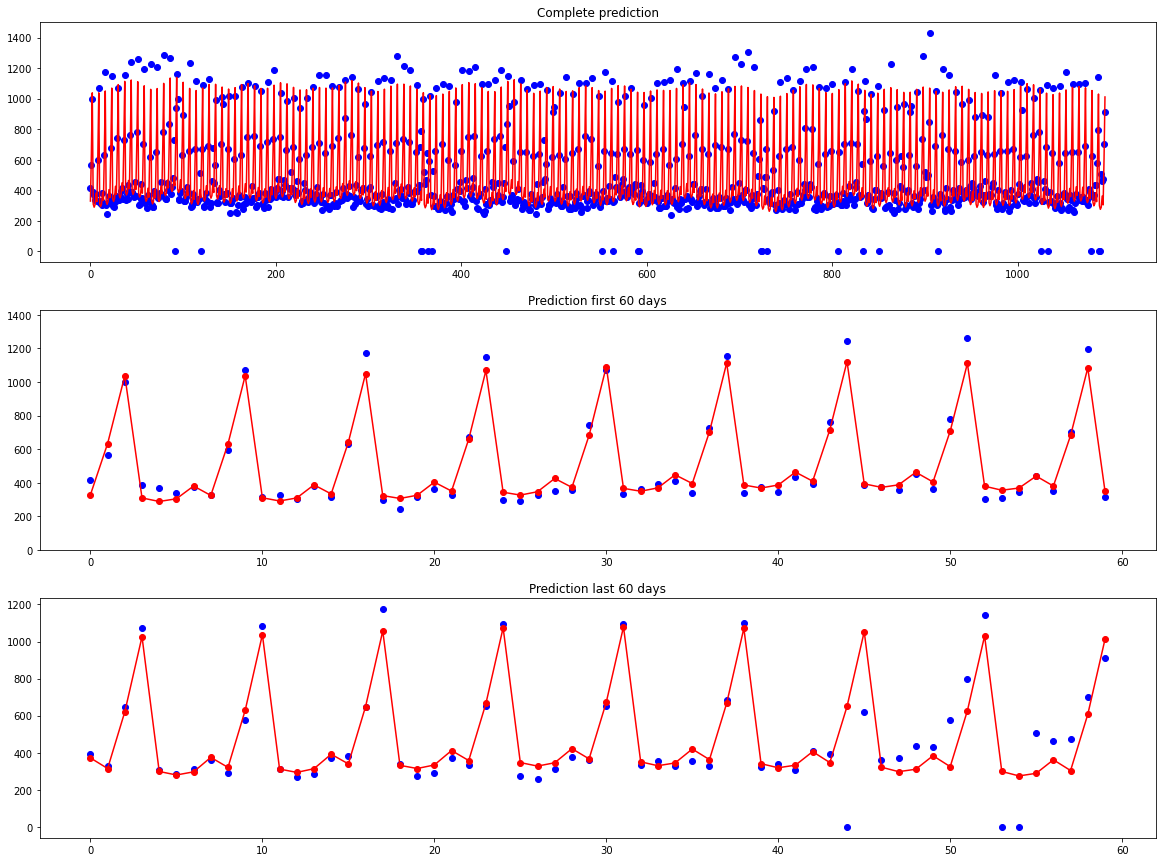

In [492]:
plot_prediction(y_true,y_predict)

## FB Prophet (no add. features)

FB Prophet is an easy to use forecasting tool that does not rely on trends being erased or other extensive data preparation. I thus regard it's usage as a low hanging fruit to quickly build a model that will hopefully beat the naive base model. 

In [412]:
for article in article_selection:
    data = pd.DataFrame.from_dict({'ds':train_fil_3.index,'y':train_fil_3[article]})
    model = Prophet()
    model.fit(data)
    future = model.make_future_dataframe(periods=365)
    prediction = model.predict(future)
    rmse = np.sqrt(metrics.mean_squared_error(validation_fil_3[article],prediction.loc[(prediction['ds']>= validation_fil_3.index.min())]['yhat']))
    print(f'Filiale {store}, Article {article}, RMSE:{rmse}')


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Filiale 3, Article 1, RMSE:24.905594970912993


/Users/leo/anaconda3/envs/nf/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



Filiale 3, Article 6, RMSE:99.29055453769564


In [459]:
get_mape(y_true,y_predict)

10.057028017635414

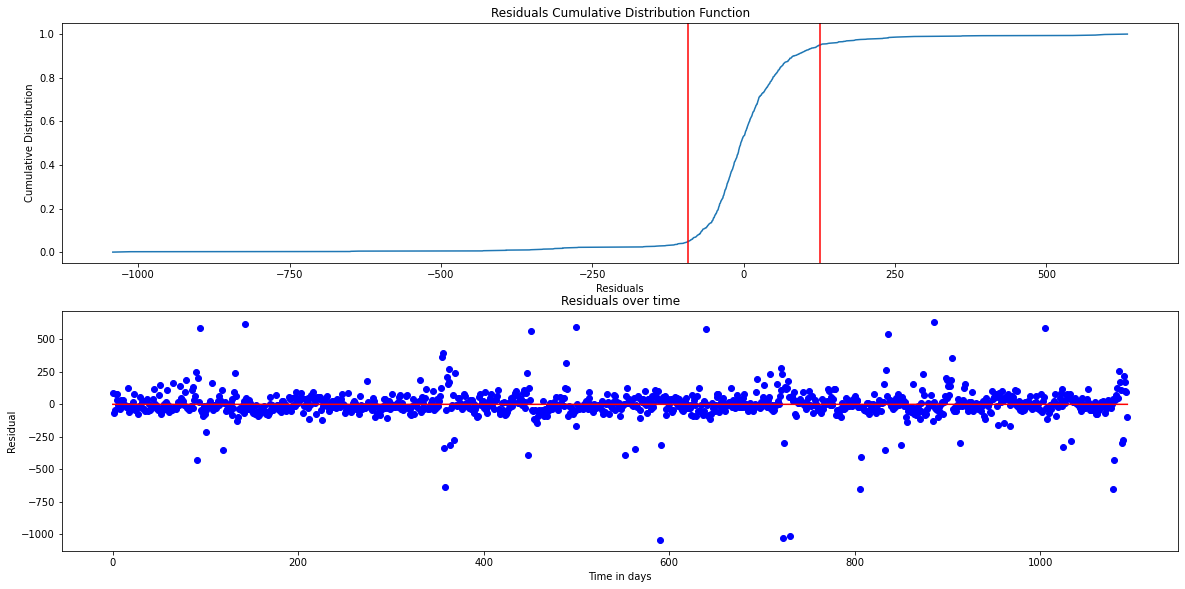

In [455]:
residual_cdf(y_true - y_predict)

## ARIMA

ARIMA models have 3 hyperparameters that can be tuned: p,d and q. We wil later use a grid search to automatically find the best fitting parameters. First, we will have a little look at the data so that we can set the range for the grid search as small and smart as possible, to minimize computing time.

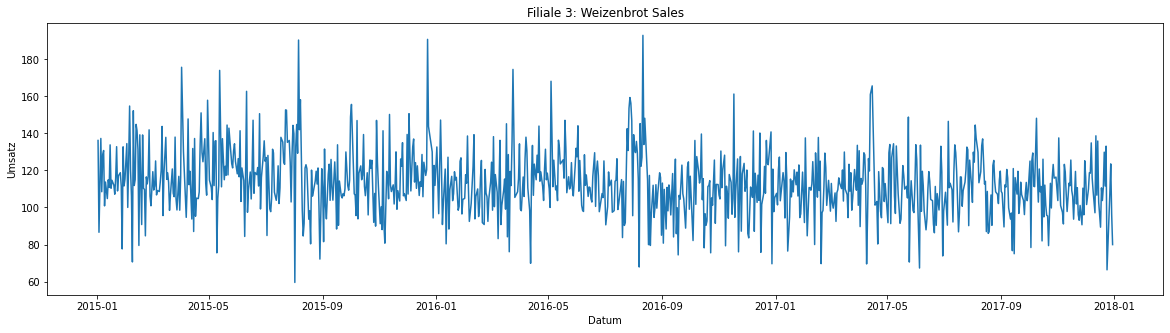

In [82]:
plt.figure(figsize=(20,5))
sns.lineplot(x=train_df.loc[(train_df.Artikelgruppe == 1)&(train_df.Filiale == 3)].index,y=train_df.loc[(train_df.Artikelgruppe == 1)&(train_df.Filiale == 3)].Umsatz)
plt.title('Filiale 3: Weizenbrot Sales');